# Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from cv2 import cv2
from skimage import feature
from sklearn import neighbors


# Retrieve Dataset

In [4]:
from preprocess import retrieve_dataset, preprocess, to_np

(train_ds_raw, test_ds_raw), metadata = retrieve_dataset(should_shuffle_files=True)

train_ds = preprocess(train_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 300,
  'is_grayscale': False, 
  'is_downsample64': False,
  'is_downsample128': False, 
  'is_normalize': False,
})

test_ds = preprocess(test_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 75,
  'is_grayscale': False, 
  'is_downsample64': False, 
  'is_downsample128': False, 
  'is_normalize': False,
})

def count_class(counts, batch):
    labels = batch[1]
    for i in range(9):
        cc = tf.cast(labels == i, tf.int32)
        counts[i] += tf.reduce_sum(cc)
    return counts

initial_state = dict((i, 0) for i in range(9))
counts = train_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for train dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

initial_state = dict((i, 0) for i in range(9))
counts = test_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for test dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

Class breakdown for train dataset:
[(0, 33), (1, 24), (2, 24), (3, 47), (4, 31), (5, 45), (6, 35), (7, 30), (8, 31)]
Class breakdown for test dataset:
[(0, 7), (1, 11), (2, 8), (3, 4), (4, 7), (5, 11), (6, 14), (7, 6), (8, 7)]


# Extract X_train, Y_train, X_test, Y_test

In [5]:
train_ds_numpy = to_np(train_ds)
test_ds_numpy = to_np(test_ds)

In [6]:
X_train = [example for example, label in train_ds_numpy]
y_train = [label for example, label in train_ds_numpy]

X_test = [example for example, label in test_ds_numpy]
y_test = [label for example, label in test_ds_numpy]

# Visualize Preprocessed Dataset

Length of X_train: 300
Length of X_test: 75


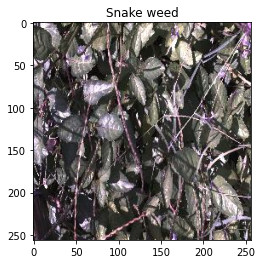

In [7]:
from visualize import visualize, compare

visualize(X_train[0], y_train[0], metadata)
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

# Perform Transfer Learning

In [8]:
from transfer_learning import init_conv_base, extract_features
conv_base = init_conv_base(X_train[0])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [9]:
train_features, train_labels = extract_features(conv_base, X_train, y_train)  # Agree with our small dataset size
test_features, test_labels = extract_features(conv_base, X_test, y_test)

# Flatten To Feed into KNN

In [10]:
X_train_flatten = list(map(lambda x: x.flatten(), train_features))
y_train = train_labels
X_test_flatten = list(map(lambda x: x.flatten(), test_features))
y_test = test_labels

print(train_labels.shape)
print("feature size now:", X_train[0].shape) # orginal feature is of dimension 196608

(300,)
feature size now: (256, 256, 3)


In [11]:
# For KNN, K Fold is just to look at prediction across various sets of data
X_full = list(X_train_flatten) + list(X_test_flatten)
y_full = list(y_train) + list(y_test)

print(len(X_full))
print(len(y_full))

375
375


# Test Model with K Fold Validation

In [12]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import kfold_cross_validation

In [17]:
n_neighbors_arr = [5, 10, 15, 20]
k = 5
clfs_and_accuracies = []

for n_neighbors in n_neighbors_arr:
  clf_and_accuracy = kfold_cross_validation(k, X_full, y_full, 'knn', {'n_neighbors': n_neighbors})
  clfs_and_accuracies.append(clf_and_accuracy)

Running 5-fold cross validation for knn with {'n_neighbors': 5}
Split accuracy: 0.30666666666666664
Split accuracy: 0.30666666666666664
Split accuracy: 0.29333333333333333
Split accuracy: 0.38666666666666666
Split accuracy: 0.28
Completed 5-fold cross validation for knn with {'n_neighbors': 5}
Obtained average accuracy of: 0.31466666666666665

Running 5-fold cross validation for knn with {'n_neighbors': 10}
Split accuracy: 0.29333333333333333
Split accuracy: 0.3333333333333333
Split accuracy: 0.32
Split accuracy: 0.3333333333333333
Split accuracy: 0.26666666666666666
Completed 5-fold cross validation for knn with {'n_neighbors': 10}
Obtained average accuracy of: 0.30933333333333335

Running 5-fold cross validation for knn with {'n_neighbors': 15}
Split accuracy: 0.29333333333333333
Split accuracy: 0.25333333333333335
Split accuracy: 0.36
Split accuracy: 0.37333333333333335
Split accuracy: 0.25333333333333335
Completed 5-fold cross validation for knn with {'n_neighbors': 15}
Obtained av

In [18]:
print(clfs_and_accuracies)

[(KNeighborsClassifier(), 0.38666666666666666), (KNeighborsClassifier(n_neighbors=10), 0.3333333333333333), (KNeighborsClassifier(n_neighbors=15), 0.37333333333333335), (KNeighborsClassifier(n_neighbors=20), 0.30666666666666664)]


In [19]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import get_precision_scores

In [21]:
for clf_and_accuracy in clfs_and_accuracies:
  (clf, accuracy) = clf_and_accuracy
  print(get_precision_scores(clf, X_full, y_full))

{'accuracy': 0.52, 'macro_avg': 0.5579656797827958, 'f1_score_macro': 0.5197955971413407, 'micro_avg': 0.52, 'f1_score_micro': 0.52, 'roc_auc_score': 0.8905942685775076}
{'accuracy': 0.43733333333333335, 'macro_avg': 0.5451966202909599, 'f1_score_macro': 0.4309489290543155, 'micro_avg': 0.43733333333333335, 'f1_score_micro': 0.43733333333333335, 'roc_auc_score': 0.8728708411945643}
{'accuracy': 0.42933333333333334, 'macro_avg': 0.5169530685592963, 'f1_score_macro': 0.43049573471986247, 'micro_avg': 0.42933333333333334, 'f1_score_micro': 0.4293333333333333, 'roc_auc_score': 0.8680329931869681}
{'accuracy': 0.35733333333333334, 'macro_avg': 0.4810433638764821, 'f1_score_macro': 0.343588432853232, 'micro_avg': 0.35733333333333334, 'f1_score_micro': 0.35733333333333334, 'roc_auc_score': 0.8568398837104537}
